## Example 4: masked 4 with bimodal posterior

In [1]:
import os
%pylab inline
import pickle

Populating the interactive namespace from numpy and matplotlib


In [2]:
param_file = 'params_mnist_-1_8_infoGAN_AE_v2_full_sigma'

PROJECT_PATH = "/global/homes/v/vboehm/codes/RNF" 
PARAMS_PATH = os.path.join(PROJECT_PATH,'params')

OLD_ROOT = '/global/scratch/vboehm/rnf/'
NEW_ROOT = '/global/cscratch1/sd/vboehm/RNF/'

In [3]:
params   = pickle.load(open(os.path.join(PARAMS_PATH,param_file+'.pkl'),'rb'))

In [4]:
import tensorflow.compat.v1 as tf
#To make tf 2.0 compatible with tf1.0 code, we disable the tf2.0 functionalities
tf.disable_eager_execution()
import tensorflow_probability as tfp
import tensorflow_hub as hub
tfd = tfp.distributions
tfb = tfp.bijectors

In [5]:
params['module_dir'] = params['module_dir'].replace(OLD_ROOT,NEW_ROOT)
params['data_dir']   = os.path.join('/global/cscratch1/sd/vboehm/RNF/datasets')

In [6]:
params['plot_dir']

'/global/homes/v/vboehm/codes/RNF/plots/mnist/class-1/latent_size8/net_type_infoGAN/loss_AE/v2_full_sigma/nsf2'

In [7]:
generator_path   = os.path.join(params['module_dir'],'decoder')
encoder_path     = os.path.join(params['module_dir'],'encoder')
nvp_path         = os.path.join(params['module_dir'],'nsf2')

In [8]:
import sys
sys.path.append('/global/homes/v/vboehm/codes/RNF/')

from rnf.load_data import load_mnist

load_func                                         = load_mnist
x_train, y_train, x_valid, y_valid, x_test, y_test = load_func(params['data_set'],flatten=False)

if np.all(x_test)==None:
    x_test=x_valid
    
def add_noise(x,sigma=0.1):
    nn = np.random.normal(size=np.shape(x))
    x  = x+nn*sigma
    return x

x_train    = add_noise(x_train)/255.-0.5
x_test     = add_noise(x_test)/255.-0.5
x_valid    = add_noise(x_valid)/255.-0.5

In [9]:
data_dim    = 28*28
data_size   = params['batch_size']
sigma_n     = (params['full_sigma']+1e-4).reshape((1,28*28,1)).astype(np.float32)
noise_n     = sigma_n
hidden_size = params['latent_size']
n_channels  = 1
seed        = 777


# settings for reconstruction with uncorrupted data
# corr_type   = 'none'
# num_mnist   = 6
# label       = 'uncorrupted'
# noise_level = 0.0
# num_comp    = 2

# settings for reconstrcution with rectangular mask
corr_type   = 'mask'
num_mnist   = 6
label       = 'solidmask'
noise_level = 0.0
params['plot_dir']   = os.path.join(PROJECT_PATH,'plots',label+'_'+str(num_mnist))

#settings for reconstruction with sparse mask 
# corr_type   = 'sparse mask'
# num_mnist   = 1
# label       = 'sparse95'
# noise_level = 0.
# num_comp    = 2

# settings for reconstruction with noise
# corr_type   = 'noise'
# num_mnist   = 6
# label       = 'noise05'
# noise_level = 0.5
# num_comp    = 4

# settings for reconstruction with noise and mask
# corr_type   = 'noise+mask'
# num_mnist   = 6
# label       = 'masknoise05'
# noise_level = 0.5
# num_comp    = 2

In [10]:
def plot_image(image, save=True, directory='./plots/',filename='plotted_image', title='image',vmin=None,vmax=None, mask=None):
  
  if np.any(mask==None):
    mask=np.ones((28,28))
  mask = np.reshape(mask,(28,28))
  plt.figure()
  #plt.title(title)
  plt.imshow((image).reshape((28,28))*mask,cmap='gray',vmin=vmin, vmax=vmax)
  plt.axis('off')
  #plt.colorbar()
  if save: 
    plt.savefig(directory+filename+'.pdf',bbox_inches='tight')
  plt.show()
  
  return True

def get_custom_noise(shape, signal_dependent=False, signal =None, sigma_low=0.07, sigma_high=0.22, threshold=0.02 ):
  
  sigma = sigma_n
  
  if signal_dependent: 
    for ii in range(data_size):
      sigma[ii][np.where(signal[ii]<=threshold)]= sigma_low
      sigma[ii][np.where(signal[ii]>threshold)]= sigma_high
      
  data_noise = np.ones_like(sigma)*noise_level
  
  sigma = np.sqrt(sigma**2+data_noise**2)
  
  return sigma
  

def make_corrupted_data(x_true, corr_type='mask'):
  
  mask = np.ones((28,28))
  
  if corr_type=='mask':
    
    minx = 10
    maxx = 24
    
    mask[0:28,minx:maxx]=0.
    
    corr_data = x_true*mask[None,:,:,None]
    
  elif corr_type=='sparse mask':
    
    mask    = np.ones(data_dim, dtype=int)
    percent = 95
    np.random.seed(seed+2)
    indices = np.random.choice(np.arange(data_dim), replace=False,size=int(percent/100.*data_dim))
    print('precentage masked:', len(indices)/data_dim)
    mask[indices] =0 
  
    corr_data = x_true*mask[None,:,:]
    
  elif corr_type=='noise':
    
    np.random.seed(seed+2)
    noise = np.random.randn(data_dim*data_size)*noise_level
    
    corr_data = x_true+noise
    
  elif corr_type=='noise+mask':
    
    np.random.seed(seed+2)
    noise = np.random.randn(data_dim*data_size)*noise_level
    
    minx = 14
    maxx = 28
    
    mask[0:28,minx:maxx]=0.
    mask = mask.reshape((28,28))
    
    corr_data = x_true+noise
    corr_data = corr_data*mask[None,:,:]
    
  elif corr_type=='none':
    
    corr_data = x_true
    
  corr_data = np.expand_dims(corr_data,-1)
  
  mask = mask.flatten()
  
  return corr_data, mask

In [11]:
def fwd_pass(generator,nvp,z,mask):
  
  fwd_z           = nvp({'z_sample':np.zeros((1,hidden_size)),'sample_size':1, 'u_sample':z},as_dict=True)['fwd_pass']
  fwd_z           = generator({'z':z},as_dict=True)['x']
  gen_z           = tf.boolean_mask(tf.reshape(fwd_z,[data_size,data_dim,n_channels]),mask, axis=1)

  return gen_z


def get_likelihood(generator,nvp,z,sigma,mask):
  
  gen_z           = fwd_pass(generator,nvp,z,mask)
  
  sigma           = tf.boolean_mask(sigma,mask, axis=1)

  likelihood      = tfd.Independent(tfd.MultivariateNormalDiag(loc=gen_z,scale_diag=sigma))

  return likelihood

def get_prior():
  
  return tfd.MultivariateNormalDiag(tf.zeros([data_size,hidden_size]), scale_identity_multiplier=1.0, name ='prior')

def get_log_posterior(z,x,generator,nvp,sigma,mask, beta):
  
  likelihood      = get_likelihood(generator,nvp,z,sigma,mask)
  
  prior           = get_prior()
  
  masked_x        = tf.boolean_mask(x,mask, axis=1)
  
  log_posterior   = prior.log_prob(z)+likelihood.log_prob(masked_x)*beta
  
  return log_posterior


def get_recon(generator,nvp, z,sigma,mask):
  
  prob = get_likelihood(generator,nvp, z,sigma,mask)
  
  recon= prob.mean()
  
  return recon

def get_hessian(func, z):
  
  hess             = tf.hessians(func,z)
  hess             = tf.gather(hess, 0)
  
  return(tf.reduce_sum(hess, axis = 2 ))


def get_GN_hessian(generator,nvp,z,mask,sigma):


  gen_z            = fwd_pass(generator,nvp,z,mask)
  
  sigma            = tf.boolean_mask(sigma,mask, axis=1)

  grad_g           = tf.gather(tf.gradients(gen_z/(sigma),z),0)

  grad_g2          = tf.einsum('ij,ik->ijk',grad_g,grad_g)

  one              = tf.linalg.eye(hidden_size, batch_shape=[data_size],dtype=tf.float32)

  hess_GN          = one+grad_g2
  
  return hess_GN
  
def compute_covariance(hessian):
  
  hessian = transform_diagonal(hessian, None, 1e-4)
  cov = tf.linalg.inv(hessian)
  
  cov = (cov+tf.linalg.transpose(cov))*0.5
  
  return cov

In [12]:
def minimize_posterior(initial_value, x, custom_mask, noise, my_sess, annealing =True):
  
  ini = np.reshape(initial_value,[data_size,hidden_size])
  
  my_sess.run(MAP_reset,feed_dict={input_data: x, MAP_ini:ini, mask:custom_mask,sigma_corr:noise})
  
  pos_def = False

  
  posterior_loss = []
  for lrate, numiter in zip([1e-1,1e-2,1e-3,1e-4],[10000,10000,10000,10000]):
    print('lrate', lrate)
    for jj in range(numiter):
      if annealing and lrate==1e-1:
        inv_T= np.round(0.5*np.exp(-(1.-jj/numiter)),decimals=1)
      else:
        inv_T= 1.
      _, ll = my_sess.run([opt_op_MAP,loss_MAP],feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise, lr: lrate, inverse_T:inv_T})
      posterior_loss.append(ll)
      if jj%1000==0:
        print('iter', jj, 'loss', ll,r'inverse T', inv_T)
        
  z_value = my_sess.run(MAP,feed_dict={input_data: x, mask:custom_mask, sigma_corr:noise})
  
  eig     = my_sess.run(tf.linalg.eigvalsh(hessian[0]),feed_dict={input_data: x, mask:custom_mask,sigma_corr:noise})
  hess    = my_sess.run(hessian[0],feed_dict={input_data: x, mask:custom_mask,sigma_corr:noise})
  hessGN  = my_sess.run(hessian_GN[0],feed_dict={input_data: x, mask:custom_mask,sigma_corr:noise})
  print('eig', eig)
  if np.all(eig>0.):
    pos_def = True
  
  loss    = ll
  plt.figure()
  plt.plot(posterior_loss)
  plt.ylabel('loss')
  plt.xlabel('iteration')
  plt.show()
  
  return z_value, loss, pos_def, hess, hessGN
  

In [13]:
def get_laplace_sample(num,map_value,x,mymask,noise,my_sess):
  
  my_sess.run(MAP_reset,feed_dict={MAP_ini:map_value})
  my_sess.run(update_mu)
  my_sess.run(update_TriL,feed_dict={input_data: x, mask: mymask, sigma_corr:noise})
  
  samples=[]
  for ii in range(num):
    my_sess.run(posterior_sample,feed_dict={input_data: x, sigma_corr:noise})
    samples.append(my_sess.run(recon,feed_dict={input_data: x, sigma_corr:noise}))
    
  samples=np.asarray(samples)
  return samples

def get_gmm_sample(num,x,mymask,noise,my_sess):
  
  samples=[]
  for ii in range(num):
    samples.append(my_sess.run(gmm_recon,feed_dict={input_data: x, sigma_corr:noise}))
    
  samples=np.asarray(samples)
  return samples

In [14]:
def plot_samples(samples, mask, title='samples', filename='samples'):
  plt.figure()
  plt.title(title)
  for i in range(min(len(samples),16)):
      subplot(4,4,i+1)
      imshow(np.reshape(samples[i,:],(28,28)),vmin=-0.2,vmax=1.2, cmap='gray')
      axis('off')
  plt.savefig(plot_path+filename+'.pdf',bbox_inches='tight')
  plt.show()
  
  if corr_type in ['mask', 'sparse mask', 'noise+mask']:
    plt.figure()
    plt.title('masked'+title)
    for i in range(min(len(samples),16)):
        subplot(4,4,i+1)
        imshow(np.reshape(samples[i,0,:,0]*mask,(28,28)),vmin=-0.2,vmax=1.2, cmap='gray')
        axis('off')     
    plt.savefig(plot_path+filename+'masked.pdf',bbox_inches='tight')
    plt.show()

In [15]:
def get_random_start_values(num, my_sess):
  result=[]
  for ii in range(num):
    result.append(my_sess.run(get_prior().sample()))
  return result

In [16]:
def get_chi2(sigma,data,mean,masking=True, mask=None,threshold=0.02):
  
  if masking:
    mask = np.reshape(mask,data.shape)
    data = data[np.where(mask==1)]
    mean = mean[np.where(mask==1)]
    sigma= sigma[np.where(mask==1)]
    
  
  low = min(sigma.flatten())
  high= max(sigma.flatten())
  
  chi2_tot = np.sum((data-mean)**2/sigma**2)
  dof_tot  = len(np.squeeze(data))
  
  if corr_type not in ['noise','noise+mask']:
    chi2_low = np.sum((data[np.where(data<=threshold)]-mean[np.where(data<=threshold)])**2/sigma[np.where(data<=threshold)]**2)
    dof_low  = len(np.squeeze(data[np.where(data<=threshold)]))
    chi2_high= np.sum((data[np.where(data>threshold)]-mean[np.where(data>threshold)])**2/sigma[np.where(data>threshold)]**2)
    dof_high = len(np.squeeze(data[np.where(data>threshold)]))
  else:
    chi2_low = None
    dof_low  = None
    chi2_high= None
    dof_high = None
  
  return chi2_tot, dof_tot, chi2_low, dof_low, chi2_high, dof_high, masking

In [17]:
def plot_minima(minima, losses, var):

  plt.figure()
  plt.title('Minimization result')
  plt.plot(np.arange(len(losses)),losses,ls='',marker='o')
  plt.xlabel('# iteration')
  plt.ylabel('loss')
  plt.savefig(plot_path+'minimzation_results_%s.pdf'%(label),bbox_inches='tight')
  plt.show()
  
  colors = matplotlib.colors.Normalize(vmin=min(losses), vmax=max(losses))
  cmap   = matplotlib.cm.get_cmap('Spectral')
  
  var = np.squeeze(var)
  plt.figure()
  plt.title('value of hidden variables at minima')
  for ii in range(len(minima)):
  
    yerr_= np.sqrt(var[ii])

    plt.errorbar(np.arange(hidden_size),np.squeeze(minima)[ii], marker='o',ls='', c=cmap(colors(losses[ii])), mew=0, yerr=yerr_, label ='%d'%losses[ii])
  plt.legend(ncol=4, loc=(1.01,0))
  plt.xlabel('# hidden variable')
  plt.ylabel('value')
  plt.savefig(plot_path+'hidden_values_at_minima_%s.pdf'%(label),bbox_inches='tight')
  plt.show()

In [18]:
# def probe_posterior(minimum, x, noise, mymask, my_sess, filename=label):

#   _ = my_sess.run(MAP_reset,feed_dict={input_data: x, MAP_ini:minimum, sigma_corr:noise})
#   _ = my_sess.run(update_mu,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
#   _ = my_sess.run(update_TriL,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  
#   exact_hessian = sess.run(hessian,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
#   approx_hessian= sess.run(GN_hessian,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
#   ll0 = sess.run(loss_MAP,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
  
  
#   plt.figure(figsize=(20,5))
  
#   for nn in np.arange(hidden_size):
#     H    = exact_hessian[0,nn,nn]
#     HGN  = approx_hessian[0,nn,nn]

#     losses=[]
    
    
#     subplot(2,5,nn+1)
#     title('latent space direction %d'%nn)
    
#     Delta   = 0.1
#     steps   = 1000
#     delta_z = np.zeros((steps,hidden_size))

#     delta_z[:,nn] = (np.arange(steps)-steps//2)*Delta/steps
#     new_ini       = delta_z+minimum

#     for ii in range(steps):
#       _ = sess.run(MAP_reset,feed_dict={input_data: x, mask:mymask, MAP_ini:np.expand_dims(new_ini[ii],axis=0), sigma_corr:noise})
#       ll = sess.run(loss_MAP,feed_dict={input_data: x, mask:mymask, sigma_corr:noise})
#       losses.append(ll)
     

    

#     plt.plot(new_ini[:,nn],ll0+H*delta_z[:,nn]**2,label='estimate from exact Hessian')
#     #plt.plot(new_ini[:,nn],ll0+HGN*delta_z[:,nn]**2,label='estimate from Gauss-Newton')
#     plt.plot(new_ini[:,nn],losses,label='probed posterior', lw=2)
#     plt.xlabel('z')
#     plt.ylabel('negative log posterior')
#     plt.ylim(min(losses),min(losses)+1.5)

#   plt.tight_layout()
#   plt.legend(loc=(1.02,1.7))
  
  
  
#   plt.savefig(plot_path+'probing_posterior_%s.png'%(filename),bbox_inches='tight')
#   plt.show()


In [19]:
def get_gmm_parameters(minima, x, noise, mymask, offset):
  mu   =[]
  w    =[]
  sigma=[]
  print(len(minima), num_comp)
  for ii in range(num_comp):

    # do Laplace approximation around this minimum
    mu+=[minima[ii][0]]

    sess.run(MAP_reset,feed_dict={MAP_ini:minima[ii]})
    sigma+=[sess.run(update_TriL,feed_dict={input_data: x, sigma_corr:noise, mask: mymask})]

    # correct weighting of different minima according to El20 procedure, with samples at the maxima and well seperated maxima
    logdet  = sess.run(tf.linalg.logdet(covariance[0]),feed_dict={input_data: x, sigma_corr:noise, mask: mymask})
    logprob = sess.run(nlPost_MAP,feed_dict={input_data: x, sigma_corr:noise, mask: mymask})
    w+=[np.exp(0.5*logdet+logprob+offset)]
  print(np.asarray(w).shape)
  print('weights of Gaussian mixtures:', np.asarray(w)[:,0]/np.sum(np.asarray(w)[:,0]))
  mu     = np.reshape(np.asarray(mu),[1,num_comp,hidden_size])
  sigma  = np.reshape(np.asarray(sigma)[:,0],[1,num_comp,hidden_size,hidden_size])
  w      = np.squeeze(np.asarray(w)[:,0])
                         
  return mu, sigma, w
                                 

In [20]:
def plot_prob_2D_GMM(samples, indices):

    samples = samples[:,0,:]

    samples = np.hstack((np.expand_dims(samples[:,indices[0]],-1),np.expand_dims(samples[:,indices[1]],-1)))

    figure=corner.corner(samples)
    axes = np.array(figure.axes).reshape((2, 2))

    axes[1,0].set_xlabel('latent space variable %d'%indices[0])
    axes[1,0].set_ylabel('latent space variable %d'%indices[1])
    plt.savefig(plot_path+'posterior_contour_GMM_%s_latent_space_dir_%d_%d.pdf'%(label,indices[0],indices[1]),bbox_inches='tight')
    plt.show()
    
  

In [21]:
def transform_diagonal(matrix, transform=tf.nn.softplus, add=0):
  diag = tf.linalg.diag_part(matrix)
  if transform is not None:
    diag = transform(diag)
  transformed_diag = diag+add
  new_matrix = tf.linalg.set_diag(matrix, transformed_diag)
  return new_matrix

In [22]:
tf.reset_default_graph()


sigma_corr  = tf.placeholder_with_default(noise_n,shape=[1,data_dim,n_channels])
mask        = tf.placeholder_with_default(np.ones([data_dim], dtype='float32'),shape=[data_dim])
input_data  = tf.placeholder(shape=[data_size,data_dim,n_channels], dtype=tf.float32)

inverse_T   = tf.placeholder_with_default(1., shape=[])
lr          = tf.placeholder_with_default(0.001,shape=[])

encoder     = hub.Module(encoder_path, trainable=False)
generator   = hub.Module(generator_path, trainable=False)
nvp_funcs   = hub.Module(nvp_path, trainable=False)

MAP_ini     = tf.placeholder_with_default(tf.zeros([data_size,hidden_size]),shape=[data_size,hidden_size])
MAP         = tf.Variable(MAP_ini)
MAP_reset   = tf.stop_gradient(MAP.assign(MAP_ini))

nlPost_MAP  = get_log_posterior(MAP, input_data, generator,nvp_funcs, sigma_corr,mask, inverse_T)
loss_MAP    = -nlPost_MAP[0]

optimizer   = tf.train.AdamOptimizer(learning_rate=lr)

opt_op_MAP  = optimizer.minimize(loss_MAP, var_list=[MAP])

recon_MAP   = get_recon(generator,nvp_funcs, MAP,sigma_corr,mask)

hessian            = get_hessian(-nlPost_MAP,MAP)
hessian_GN         = get_GN_hessian(generator,nvp_funcs,MAP,mask,sigma_corr)
covariance         = compute_covariance(hessian)
variance           = tf.linalg.diag_part(covariance)[0]
print(covariance)
# 

# ini_val  = np.ones((1,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
# with tf.variable_scope("Laplace_Posterior",reuse=tf.AUTO_REUSE):
#   mu_new      = tf.Variable(np.ones((1,hidden_size),dtype=np.float32), dtype=np.float32)
#   sigma_new_t = ini_val
#   sigma_new_t = transform_diagonal(tfp.math.fill_triangular(sigma_new_t))   
#   sigma_new_t2 = tf.Variable(sigma_new_t,dtype=tf.float32)
    
# update_mu          = MAP_update.assign(tf.expand_dims(MAP[0],0))

approx_posterior_laplace = tfd.MultivariateNormalFullCovariance(loc=MAP[0],covariance_matrix=covariance[0])



#update_TriL        = TriL_update.assign(tf.expand_dims(tf.linalg.cholesky(covariance[0]),0))

posterior_sample   = approx_posterior_laplace.sample(64)

recon              = get_recon(generator,nvp_funcs, posterior_sample ,sigma_corr,mask)

# ini_val2    = np.ones((1,num_comp,(hidden_size *(hidden_size +1)) // 2),dtype=np.float32)
# with tf.variable_scope("corrupted/gmm",reuse=tf.AUTO_REUSE):
#   mu_gmm      = tf.Variable(np.ones((1,num_comp,hidden_size)), dtype=np.float32)
#   sigma_gmm   = tf.Variable(tfp.math.fill_triangular(ini_val2))
#   w_gmm       = tf.Variable(np.ones((num_comp))/num_comp, dtype=np.float32)
  
# sigma_gmmt    = transform_diagonal(sigma_gmm)
# w_positive    = tf.math.softplus(w_gmm)
# w_rescaled    = tf.squeeze(w_positive/tf.reduce_sum(w_positive))

# gmm           = tfd.MixtureSameFamily(mixture_distribution=tfd.Categorical(probs=w_rescaled),components_distribution=tfd.MultivariateNormalTriL(loc=mu_gmm,scale_tril=sigma_gmmt))

# mu_ini        = tf.placeholder_with_default(tf.zeros([1,num_comp,hidden_size]),shape=[1,num_comp,hidden_size])
# sigma_ini     = tf.placeholder_with_default(tf.ones([1,num_comp,hidden_size, hidden_size]),shape=[1,num_comp,hidden_size, hidden_size])
# w_ini         = tf.placeholder_with_default(tf.ones([num_comp])/num_comp,shape=[num_comp])

# update_w      = tf.stop_gradient(w_gmm.assign(tfp.math.softplus_inverse(w_ini)))
# update_mugmm  = tf.stop_gradient(mu_gmm.assign(mu_ini))
# update_TriLgmm= tf.stop_gradient(sigma_gmm.assign(transform_diagonal(sigma_ini)))

# gmm_sample    = gmm.sample()
# gmm_sample    = tf.repeat(gmm_sample, params['batch_size'], axis=0)
# # print(gmm_sample)
# gmm_recon     = get_recon(generator,nvp_funcs, gmm_sample ,sigma_corr,mask)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Instructions for updating:
Do not pass `graph_parents`.  They will  no longer be used.
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it with `scale_diag` directly instead.
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Tensor("mul_1:0", shape=(64, 8, 8), dtype=float32)
Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tri

In [23]:
minima_path = os.path.join('../minimas/')
try:
    os.makedirs(minima_path)
except:
    pass

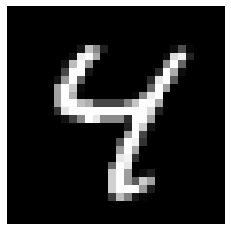

mask (64, 28, 28, 1)
(64, 28, 28, 1, 1)


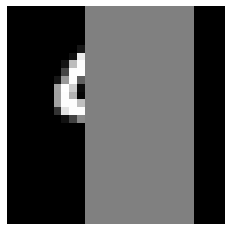

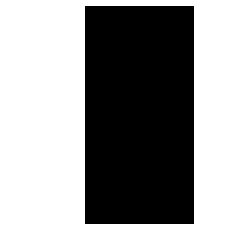

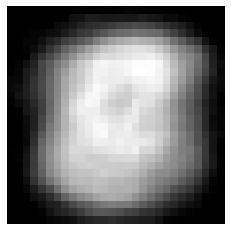

In [24]:
if __name__ == "__main__":
  sess = tf.Session()
  sess.run(tf.global_variables_initializer())
  plot_path = params['plot_dir']
  
  truth = x_test[num_mnist:num_mnist+data_size]
  plot_image(truth[0], directory=plot_path, filename='truth_%s'%label, title='truth')
  print(corr_type, truth.shape)
  data, custom_mask = make_corrupted_data(truth, corr_type=corr_type)
  print(data.shape)
  plot_image(data[0], directory=plot_path, filename='input_data_%s'%label, title='data')
  plot_image(custom_mask, directory=plot_path, filename='mask_data_%s'%label, title='mask')
  
  noise = get_custom_noise(data.shape, signal_dependent=False, signal=truth)
  plot_image(noise[0], directory=plot_path, filename='noise_%s'%label, title='noise')
  
  data = np.reshape(data,(-1,28*28,1))
  custom_mask = np.reshape(custom_mask,(28*28))
  noise = noise_n
  
  tf.random.set_random_seed(seed)
  inits = get_random_start_values(20, sess)

  try:
    minima, min_loss, min_var,recons, hesss, hesssGN = pickle.load(open(minima_path+'minima_%s.pkl'%label,'rb'))
  except:
  
    minima  =[]
    min_loss=[]
    min_var =[]
    recons  =[]
    hesss   =[]
    hesssGN =[]
    for jj,init in enumerate(inits):
      print('progress in %', jj/len(inits)*100)
      min_z, min_l, pos_def,hess,hessGN    = minimize_posterior(init, data,custom_mask,noise,sess)
      rec                           = sess.run(recon_MAP, feed_dict={sigma_corr:noise})
      var                           = sess.run(variance, feed_dict={input_data: data,mask:custom_mask,sigma_corr:noise})
  
      plot_image(rec[0], directory=plot_path, filename='recon_%s_minimum%d'%(label,jj), title='reconstruction with loss %.1f'%min_l)
      if pos_def:
        print('hessian postive definite')
        minima.append(min_z)
        min_loss.append(min_l)
        min_var.append(var)
        recons.append(rec)
        hesss.append(hess)
        hesssGN.append(hessGN)
    
    order    = np.argsort(min_loss)
    min_loss = np.asarray(min_loss)[order]
    minima   = np.asarray(minima)[order]
    min_var  = np.asarray(min_var)[order]
    hesss    = np.asarray(hesss)[order]
    hesssGN  = np.asarray(hesssGN)[order]
    
    pickle.dump([minima, min_loss, min_var,recons, hesss, hesssGN],open(minima_path+'minima_%s.pkl'%label,'wb'))

#   lowest_minimum = sess.run(MAP_reset, feed_dict={MAP_ini:minima[0]})
#   rec     = sess.run(recon_MAP, feed_dict={MAP_ini:minima[0],sigma_corr:noise})
#   plot_image(rec[0]+0.5, directory=plot_path, filename='lowest_minimum_%s'%(label), title='reconstruction', vmin=0, vmax=1)
#   if corr_type in ['mask', 'sparse mask', 'noise+mask']:
#     plot_image(rec[0]+0.5, directory=plot_path, filename='lowest_minimum_%s_masked'%(label), title='masked reconstruction', vmin=0, vmax=1, mask = custom_mask)
    
#   samples  = sess.run(posterior_sample, feed_dict={MAP_ini:minima[0],input_data: data,sigma_corr:noise})
#   print(np.std(samples-minima[0][0]))
#   recs     = sess.run(recon_MAP, feed_dict={MAP_ini:samples, sigma_corr:noise,input_data: data,sigma_corr:noise})
#   #plot_samples(recs+0.5, custom_mask, title='Samples from Laplace approximation', filename='samples_laplace_deepest_minimum_%s'%label)
#   for ii in range(16):
#     plt.subplot(4,4,ii+1)
#     plt.imshow((recs[ii]+0.5).reshape(28,28),cmap='gray')
#     plt.axis('off')
#   mu_, sigma_, w_ = get_gmm_parameters([minima[0],minima[1]], data, noise, custom_mask, min_loss[0])
#   print(sigma_,mu_,w_)
#   _ = sess.run([update_w, update_mugmm,update_TriLgmm], feed_dict={mu_ini:mu_, w_ini:w_, sigma_ini:sigma_ })

#   samples = get_gmm_sample(16,data,custom_mask,noise,sess)
#   plot_samples(samples[:,0:1,:,:]+0.5, custom_mask, title='GMM samples', filename='gmm_samples_%s'%label)
  
# #   more_samples = []
# #   for ii in range(10000):
# #     more_samples+=[sess.run(gmm_sample,feed_dict={input_data: data, sigma_corr:noise})]
# #   more_samples=np.asarray(more_samples)
  
# #   for indices in [[0,1],[1,2],[3,8]]:
# #     plot_prob_2D_GMM(more_samples, indices)
  

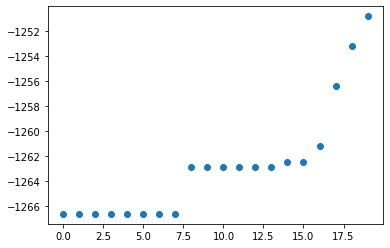

In [25]:
plt.scatter(np.arange(len(min_loss)),min_loss)

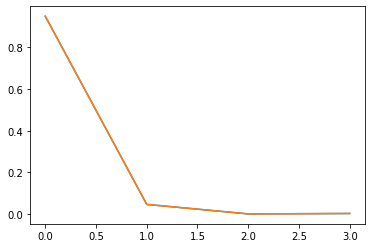

In [26]:
w=[]
for ii in [0,8,14,16]:
    hess    = hesss[ii]
    cov     = np.linalg.inv(hess)
    _, logdet = np.linalg.slogdet(cov)
    logprob   = -min_loss[ii]
    #print(logprob,logdet)
    w+=[np.exp(0.5*logdet+logprob-1000)]
w=np.asarray(w)/np.sum(np.asarray(w))
plt.plot(w)
index_gauss =np.sum(np.random.multinomial(1, w,1000000),axis=0)
_=plt.plot(index_gauss/1000000)

samples = []
for ii, n in enumerate([0,8,14,16]):
    for jj in range(index_gauss[ii]):
        cov = np.linalg.inv(hesss[n])
        samples.append(np.dot(np.linalg.cholesky(cov),np.random.randn(8))+minima[n][0])
samples=np.asarray(samples)

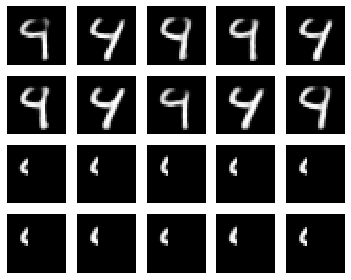

In [27]:
recs     = sess.run(MAP_reset, feed_dict={MAP_ini:samples[0:64], sigma_corr:noise,input_data: data,sigma_corr:noise})
recs     = sess.run(recon_MAP, feed_dict={MAP_ini:samples[0:64], sigma_corr:noise,input_data: data,sigma_corr:noise})

recs     = np.reshape(recs,(-1,28,28))+0.5
  #plot_samples(recs+0.5, custom_mask, title='Samples from Laplace approximation', filename='samples_laplace_deepest_minimum_%s'%label)
plt.figure(figsize=(5,4))
for ii in range(10):
    plt.subplot(4,5,ii+1)
    plt.imshow((recs[ii]).reshape(28,28),cmap='gray')
    plt.axis('off')
for ii in range(10):
    plt.subplot(4,5,10+ii+1)
    masked = recs[ii]
    masked[np.where(custom_mask.reshape(28,28)==0)]=0
    plt.imshow(masked,cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.savefig(os.path.join(params['plot_dir']+'posterior_samples_example1.pdf'),bbox_inches='tight')


# plt.figure(figsize=(5,5))
# for ii in range(32):
#     plt.subplot(8,8,ii+1)

#     plt.axis('off')
#     plt.tight_layout()
# plt.savefig(os.path.join(params['plot_dir']+'posterior_samples_maksed_example1.pdf'),bbox_inches='tight')

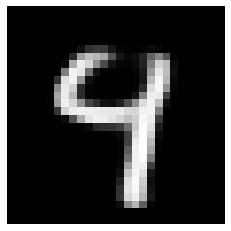

True

In [28]:
recs     = sess.run(MAP_reset, feed_dict={MAP_ini:minima[0], sigma_corr:noise,input_data: data,sigma_corr:noise})
recs     = sess.run(recon_MAP, feed_dict={MAP_ini:minima[0], sigma_corr:noise,input_data: data,sigma_corr:noise})
plot_image(recs[0], directory=plot_path, filename='reconstruction', title='reconstruction')

In [29]:
from mcmcplot import mcmcplot as mcp

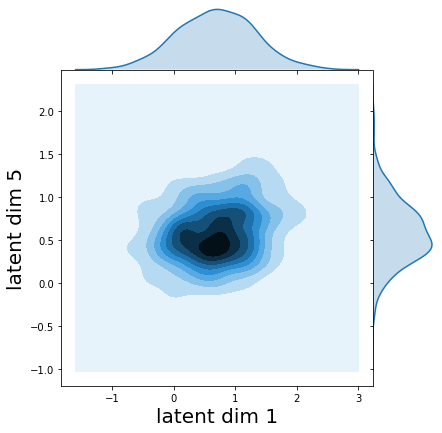

In [30]:
samples_cut=np.vstack((samples[:,1],samples[:,5])).T
samples_cut.shape
fjd, used_settings = mcp.plot_joint_distributions(
    chains=samples_cut,names=['latent dim 1', 'latent dim 5'],
    settings=None,
    return_settings=True)
a = fjd.ax_joint
tmp = a.yaxis.get_label()
tmp.set_fontsize(20)
tmp = a.xaxis.get_label()
tmp.set_fontsize(20)
plt.savefig(os.path.join(params['plot_dir']+'distribution.pdf'),bbox_inches='tight')